In [46]:
import torch
import torchvision
import numpy as np 
from tqdm import tqdm
from PIL import Image
from torch import nn 
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [47]:
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((224 , 224)),
    transforms.ToTensor()
])

train_img = ImageFolder(root=r"carpet\train" ,transform=transform)

train_data , val_data = torch.utils.data.random_split(train_img , [0.8,0.2])

train_loader = DataLoader(train_data , batch_size = batch_size , shuffle = True)
test_loader =  DataLoader(val_data , batch_size = batch_size , shuffle = True)

In [ ]:
class vae(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3 , 128 , kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256 , kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2 , stride=2),
            nn.Conv2d(256 , 256 , kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256 , 256 , kernel_size=4 , stride=2 , output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256,128 , kernel_size=5 , stride=2 , output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,3 , kernel_size=5 , stride=2 , output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_dec

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model = vae().to(device)

In [49]:
print(f"trainable params : {sum(p.numel() for p in model.parameters()if p.requires_grad)} ")

trainable params : 3457411 


In [50]:
losss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)

In [55]:
epochs = 20
loss = []
for ep in tqdm(range(epochs)):
    model.train()
    for img , _ in train_loader:
        img = img.cuda()
        out = model(img)
        loss1 = losss(out,img)

        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()
    
    loss.append(loss1.item())



100%|██████████| 20/20 [04:37<00:00, 13.90s/it]


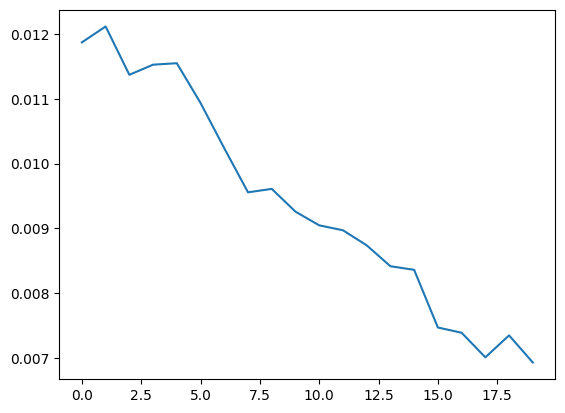

In [56]:
plt.plot(loss)
plt.show()

In [57]:
validation_loss = []
model.eval()
with torch.no_grad():
    val_loss = 0
    num = 0
    for  img , _ in test_loader:
        img = img.cuda()
        op = model(img)
        lossy = losss(op , img)
        val_loss += lossy.item()
        num+=1
    val_loss = val_loss/num
    validation_loss.append(val_loss)


torch.Size([3, 224, 224])


<Figure size 1600x1200 with 0 Axes>

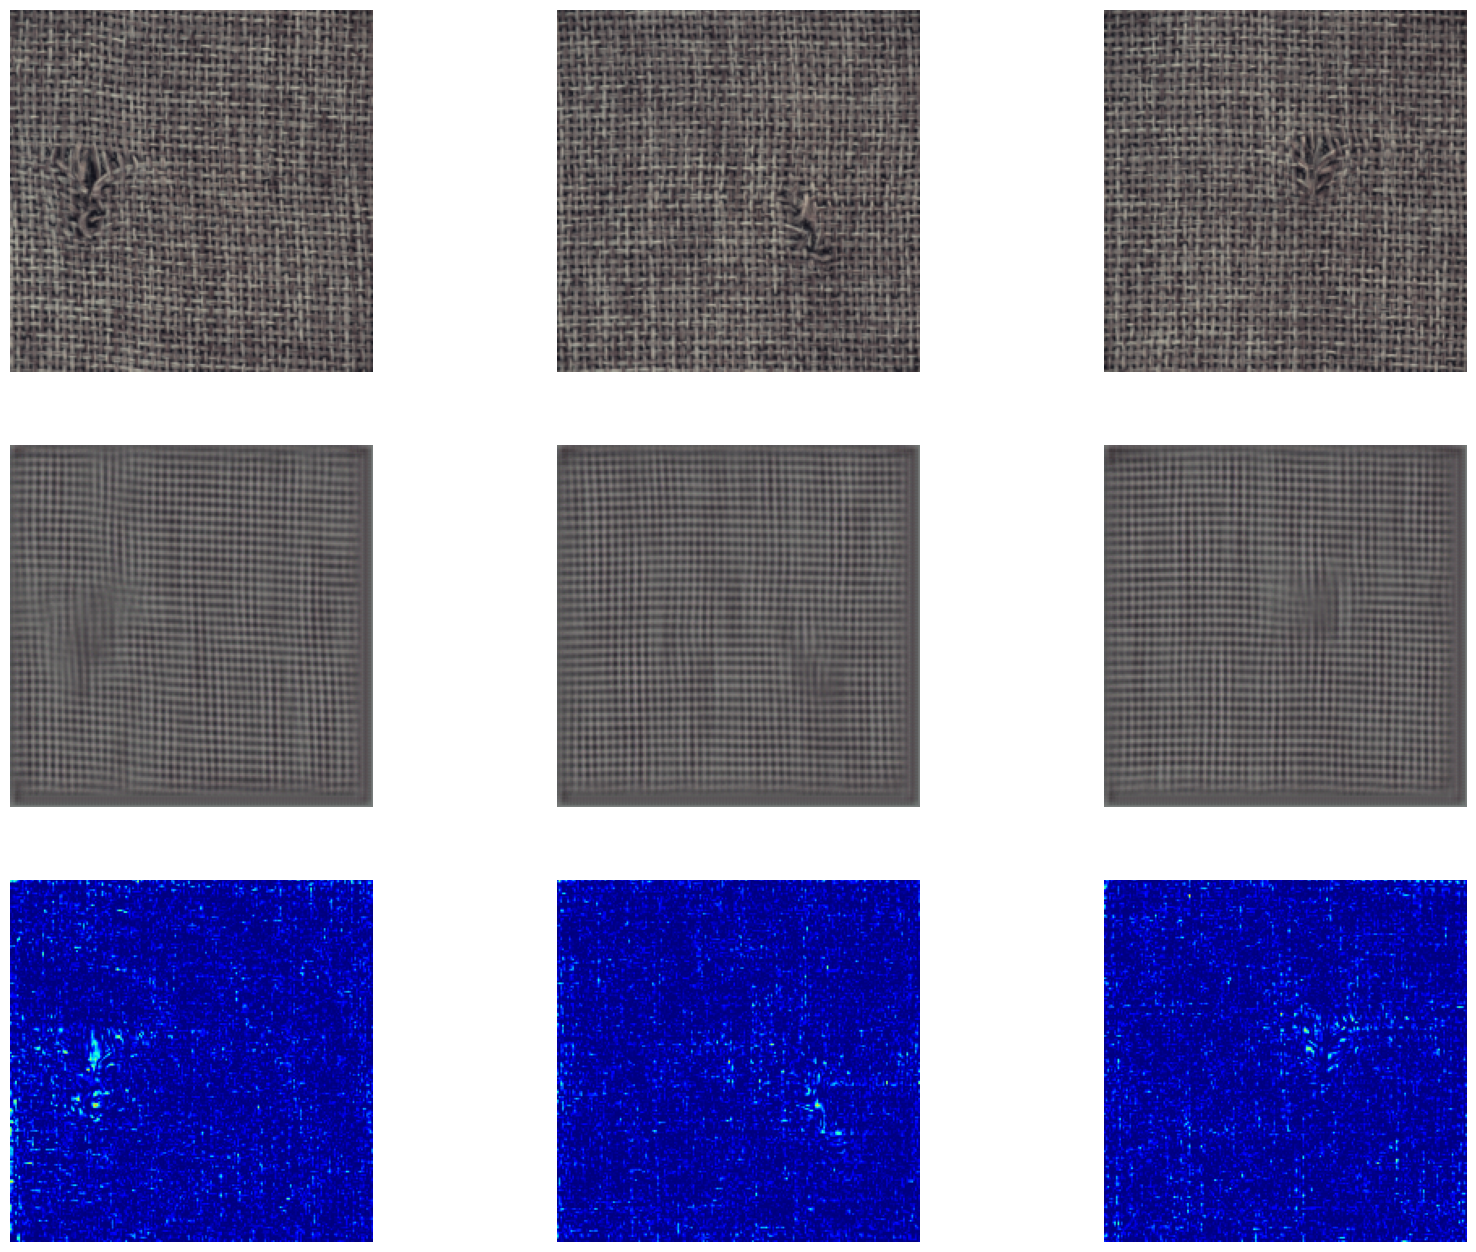

In [65]:
test1 = transform(Image.open(r"carpet\test\cut\000.png"))
test2 = transform(Image.open(r"carpet\test\cut\001.png"))
test3 = transform(Image.open(r"carpet\test\cut\002.png"))

data = torch.stack([test1,test2,test3])

model.eval()
with torch.no_grad():
    data = data.cuda()
    recon = model(data)

#model.eval()
#with torch.no_grad():
    #for img , _ in test_loader:
        #data = img.cuda()
        #recon = model(data)
        #break

recon_error = ((data - recon)**2).mean(axis =1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()